# Comparison of exact and approximative robustness curves

In [ ]:
import os
os.chdir("../")
import sys
import copy
import json
from argparse import Namespace
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper')

import provable_robustness_max_linear_regions.data as dt
from provable_robustness_max_linear_regions.mip.mip_verify import convert_mat_tf_to_mip
from generate_robustness_curves import generate_curve_data
from utils import NumpyEncoder

## Plot settings:

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', usetex=True)

# dictionary that maps color string to 'good looking' seaborn colors that are easily distinguishable
colors = {
    "orange": sns.xkcd_rgb["yellowish orange"],
    "red": sns.xkcd_rgb["pale red"],
    "green": sns.xkcd_rgb["medium green"],
    "blue": sns.xkcd_rgb["denim blue"],
    "yellow": sns.xkcd_rgb["amber"],
    "purple": sns.xkcd_rgb["dusty purple"],
    "cyan": sns.xkcd_rgb["cyan"]
}

## Calculate robustness curves:
Estimated runtime (if no file with data is present): 3 days

Note: You need to have julia and gurobi installed to run the julia script. See readme.md for installation instructions.

Exact curves:

In [5]:
def load_from_json(file_name):

    if not os.path.exists("res/" + file_name + ".json"):
        return None
    else:
        with open("res/" + file_name + ".json", 'r') as fp:
            loaded_json =  json.load(fp)

            for key in loaded_json.keys():
                loaded_json[key]["x"] = np.array(loaded_json[key]["x"])
                loaded_json[key]["y"] = np.array(loaded_json[key]["y"])

                loaded_json[key]["y"][np.isnan(loaded_json[key]["x"])] = 1.0
                loaded_json[key]["x"] = np.nan_to_num(loaded_json[key]["x"], nan = np.nanmax(loaded_json[key]["x"]))

            return loaded_json
        
def save_to_json(dictionary, file_name):
        
    if not os.path.exists("res"):
        os.makedirs("res")

    with open("res/" + file_name + ".json", 'w') as fp:
        json.dump(dictionary, fp, cls = NumpyEncoder)

n_points = 100

true_robustness_curve_data = load_from_json("true_rob_curve_data_croce_mmrat_fc1_n_points={}".format(n_points))

if not true_robustness_curve_data:
    
    true_robustness_curve_data = dict()
    
    if not os.path.exists("experiments/exact_curves/outputs"):
        os.makedirs("experiments/exact_curves/outputs")

    model_path = "provable_robustness_max_linear_regions/models/mmr+at/2019-02-14 23:20:04 dataset=mnist nn_type=fc1 p_norm=inf lmbd=1.0 gamma_rb=0.1 gamma_db=0.1 stage1hpl=10 ae_frac=0.5 epoch=100.mat"
    model_mip_path = "provable_robustness_max_linear_regions/models/mmr+at/2019-02-14 23:20:04 dataset=mnist nn_type=fc1 p_norm=inf lmbd=1.0 gamma_rb=0.1 gamma_db=0.1 stage1hpl=10 ae_frac=0.5 epoch=100_mip.mat"

    # transform model into correct format for MIP
    mat_tensorflow = scipy.io.loadmat(model_path)
    mat_mip = convert_mat_tf_to_mip(mat_tensorflow, "fc1")
    scipy.io.savemat(model_mip_path, mat_mip)

    julia_command = "julia experiments/exact_curves/exact_adversarials.jl"
    os.system(julia_command)

    true_dists = []

    for i in range(100):
        point = np.load("experiments/exact_curves/outputs/inputs_for_exact_adversarials_{}.npz".format(i+1))
        exact_adv = np.load("experiments/exact_curves/outputs/exact_adversarials_{}.npz".format(i+1))
        true_dists.append(np.linalg.norm(point.flatten() - exact_adv.flatten(), ord = np.inf))

    true_dists = np.array(true_dists)
    true_dists = np.sort(true_dists)

    true_robustness_curve_data["inf"] = dict()
    true_robustness_curve_data["inf"]["x"] = true_dists

    save_to_json(true_robustness_curve_data, "true_rob_curve_data_croce_mmrat_fc1_n_points={}".format(n_points))

Approximate curves:

In [ ]:
n_points = 100

model_path = "provable_robustness_max_linear_regions/models/mmr+at/2019-02-14 23:20:04 dataset=mnist nn_type=fc1 p_norm=inf lmbd=1.0 gamma_rb=0.1 gamma_db=0.1 stage1hpl=10 ae_frac=0.5 epoch=100.mat"

approximate_robustness_curve_data = dict()
approximate_robustness_curve_data = load_from_json("approximate_rob_curve_data_croce_mmrat_fc1_n_points={}".format(n_points))

if not approximate_robustness_curve_data:

    args = Namespace()

    args.dataset = "mnist"
    args.n_points = n_points
    args.model_path = model_path
    args.nn_type = "fc1"
    args.norms = ["inf"]
    args.save = False
    args.plot = False

    approximate_robustness_curve_data = generate_curve_data(args)

    save_to_json(approximate_robustness_curve_data, "approximate_rob_curve_data_croce_mmrat_fc1_n_points={}".format(n_points))

## Plot:

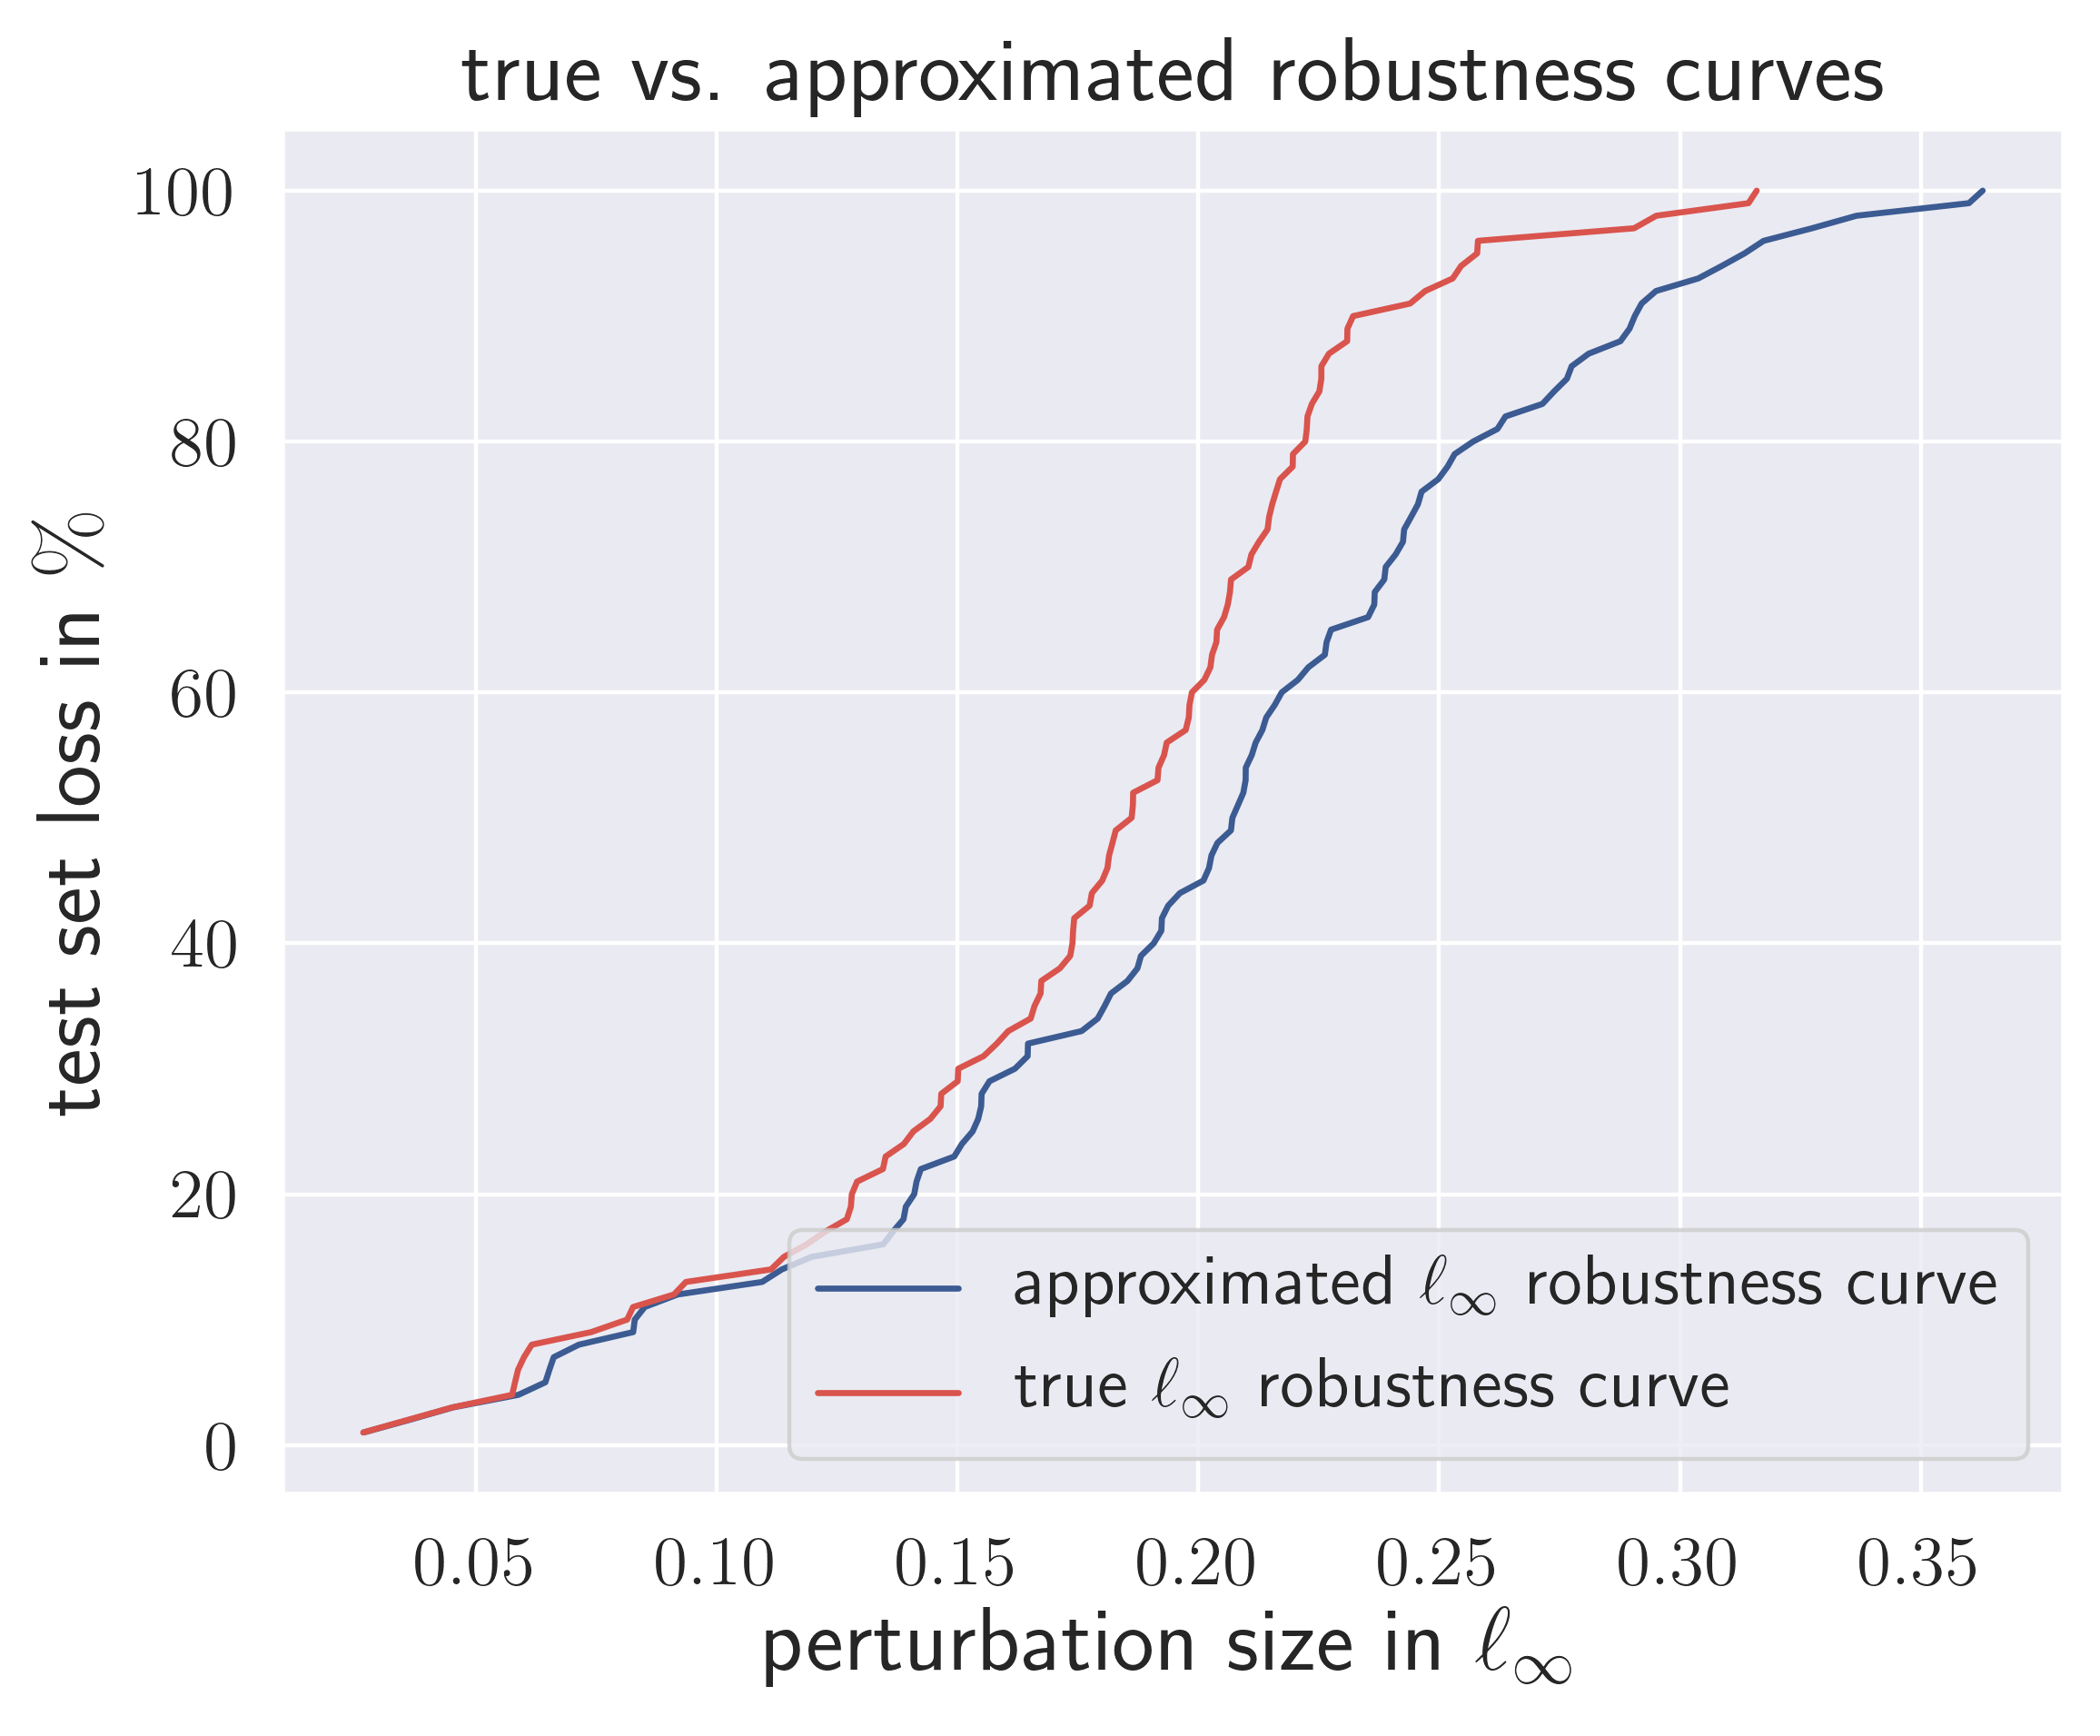

In [7]:
# name to save the plot
save_name = "fig_rc_true_vs_appr_curves"

# number of model types and parameter combinations
n_cols = 1
n_rows = 1

fig, ax = plt.subplots(n_rows,
                       n_cols,
                       figsize=(6 * n_cols, 5 * n_rows),
                       dpi=400)

ax.plot(approximate_robustness_curve_data["inf"]["x"],
        approximate_robustness_curve_data["inf"]["y"] * 100,
        c=colors["blue"],
        label="approximated $\ell_\infty$ robustness curve")
ax.plot(true_robustness_curve_data["inf"]["x"],
        approximate_robustness_curve_data["inf"]["y"] * 100,
        c=colors["red"],
        label="true $\ell_\infty$ robustness curve")

ax.legend()
ax.set_ylabel("test set loss in $\%$")
ax.set_xlabel("perturbation size in $\ell_\infty$")
ax.set_title("true vs. approximated robustness curves")

fig.tight_layout()
fig.savefig('res/{}.pdf'.format(save_name))